## Final Project: Prediksi Harga Saham Bank di Indonesia

**Karina Anggraeni - JCDSAH BSD** </br>
Dataset diambil dari aplikasi Neo HOTS (Mirae Asset Sekuritas)

Data harga saham bank yang digunakan dalam dataset ini adalah data terhadap bank swasta nasional, bank swasta asing, dan bank milik negara, yaitu:
- Bank Central Asia (BBCA) dan Bank Mega (MEGA) - swasta nasional
- Bank Woori Saudara (SDRA) dan MayBank (BNII) - swasta asing
- Bank Rakyat Indonesia (BRII) dan Bank Mandiri (BMRI) - negara

### [PART 4: Stock Price Prediction - BNII]

### 4. Modeling and Evaluation

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import os
from statsmodels.tsa.stattools import adfuller
from IPython.core.debugger import set_trace
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from IPython import display

import warnings
warnings.filterwarnings('ignore')

#### C. BNII Stock Prediction

In [2]:
bnii = pd.read_csv('df_bnii.csv', index_col = 'Date')

In [3]:
bnii_train_len = math.ceil(len(bnii)*0.8)
bnii_train_len

969

#### C.1. ARIMA Model

**ADF Stationary Test**

Augumented Dickey Fuller Test (ADF Test) digunakan untuk memeriksa stationer/ tidaknya suatu data. Test ini biasanya digunakan dalam ARIMA untuk time-series karena model ARIMA akan bekerja lebih baik pada data yang bersifat stationer.

In [4]:
bnii_adf = adfuller(bnii)

print(f'ADF Statistics: {bnii_adf[0]}')

if bnii_adf[1] > 0.05:
    print(f'p-value: {bnii_adf[1]}, data is stationary.')
else:
    print(f'p-value: {bnii_adf[1]}, data is non-stationary.')

ADF Statistics: -1.742452477867661
p-value: 0.4093829883477105, data is stationary.


Karena nilai p-value dari ADF Test terhadap BBRI melebihi 0.05 (p-value > 0.05), maka dapat disimpulkan data yang kita miliki tidak stationer.

**Manual Parameter Tuning**

Pada model ARIMA, terdapat 3 jenis parameter yang dibutuhkan ketika melakukan modeling, yaitu: </br>
- **p** menyatakan nilai variabel AR (Auto Regressive Variable/ Lag Variable) atau berapa banyak data periode sebelumnya yang akan digunakan dalam feature </br>
- **d** menyatakan nilai variabel I (Integrated Variable) atau berapa banyak diferensiasi yang perlu dilakukan agar data time-series menjadi stationer </br>
- **p** menyatakan nilai variabel MA (Moving Average Variable)

Nilai p, d, dan q dapat kita estimasi menggunakan plot ACF dan  PACF.

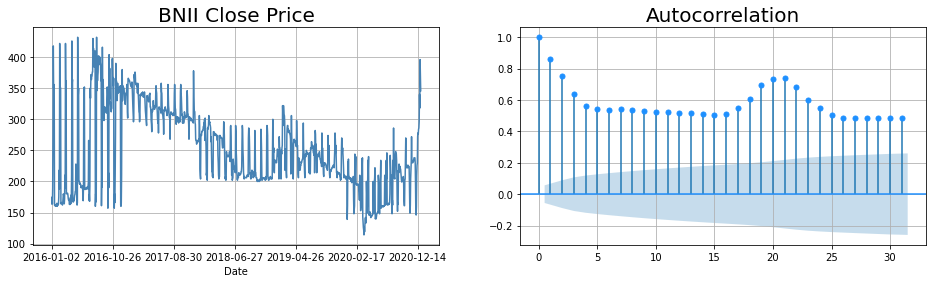

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,4))
bnii['Close'].plot(color = 'steelblue', ax = ax1)
ax1.set_title('BNII Close Price', size = 20)
ax1.grid()

plot_acf(bnii['Close'], color = 'dodgerblue', ax = ax2)
ax2.set_title('Autocorrelation', size = 20)
ax2.grid()

plt.show()

Kita akan menentukan banyaknya diferensiasi yang diperlukan dengan menggunakan _ndiffs_ dari package pmdarima.

In [6]:
ndiffs(bnii['Close'], test = 'adf')

0

Karena nilai _ndiifs_ adalah 0, berarti data harga `Close` BNII yang kita miliki tidak perlu didiferensiasi.

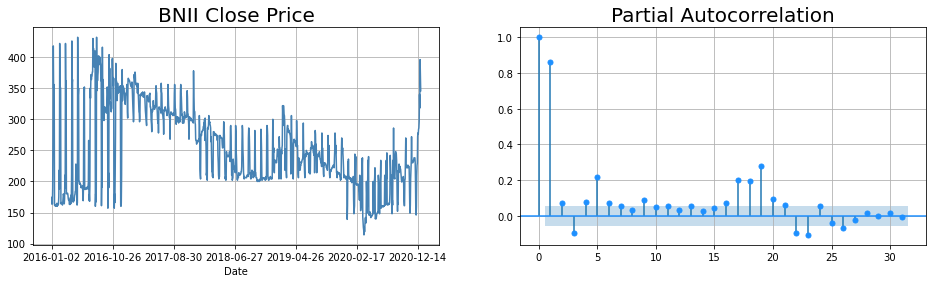

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,4))
bnii['Close'].plot(color = 'steelblue', ax = ax1)
ax1.set_title('BNII Close Price', size = 20)
ax1.grid()

plot_pacf(bnii['Close'], color = 'dodgerblue', ax = ax2)
ax2.set_title('Partial Autocorrelation', size = 20)
ax2.grid()

plt.show()

Dari plot PACF, kita pilih nilai p = 1 (nilai yang melebihi area yang diarsir/ significance line) dan nilai q = 8 (nilai yang berada di dalam significance line).

Sehingga kita dapatkan **p = 1**, **d = 0**, dan **q = 8**.

**Train Test Split**

In [8]:
bnii_arima_train = bnii['Close'][:bnii_train_len]
bnii_arima_valid = bnii['Close'][bnii_train_len:]

**Model Fitting and Evaluation**

In [9]:
bnii_arima = ARIMA(bnii_arima_train, order = (1, 0, 8))
bnii_arima_result = bnii_arima.fit()

bnii_arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  969
Model:                 ARIMA(1, 0, 8)   Log Likelihood               -4752.890
Date:                Tue, 13 Apr 2021   AIC                           9527.780
Time:                        14:22:26   BIC                           9581.419
Sample:                             0   HQIC                          9548.198
                                - 969                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        265.5520     25.152     10.558      0.000     216.255     314.848
ar.L1          0.9957      0.005    217.025      0.000       0.987       1.005
ma.L1         -0.2731      0.030     -9.062      0.000      -0.332      -0.214
ma.L2         -0.0487      0.040     -1.211      0.226      -0.128       0.030
ma.L3         -0.2479      0.024    -10.444      0.000      -0.294      -0.201
ma.L4         -0.2774      0.021    -13.040      0.000      -0.319      -0.236
ma.L5         -0.0367      0.038     -0.972      0.331      -0.111       0.037
ma.L6         -0.0387      0.036     -1.086      0.277      -0.108       0.031
ma.L7          0.0521      0.037      1.423      0.155      -0.020       0.124
ma.L8         -0.0030      0.036     -0.083      0.934      -0.073       0.067
sigma2      1063.9909     25.489     41.743      0.000    1014.033    1113.949
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13864.31
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
steps = len(bnii_arima_valid)

fc = bnii_arima_result.forecast(steps)
fc_series = pd.DataFrame(fc)

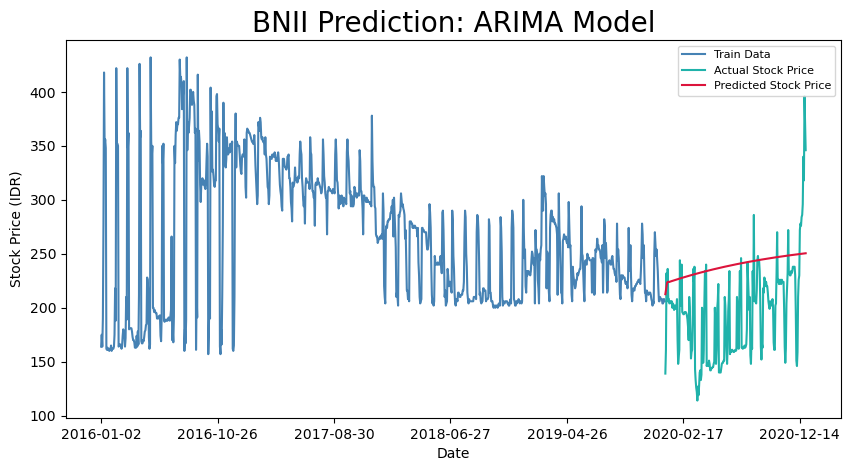

In [11]:
plt.figure(figsize = (10,5), dpi = 100)
plt.plot(bnii_arima_train, label = 'Train Data', color = 'steelblue')
plt.plot(bnii_arima_valid, label = 'Actual Stock Price', color = 'lightseagreen')
plt.plot(fc_series, label = 'Predicted Stock Price', color = 'crimson')
plt.title('BNII Prediction: ARIMA Model', size = 20)
plt.xticks(ticks = [0, 200, 400, 600, 800, 1000, 1200])
plt.xlabel('Date')
plt.ylabel('Stock Price (IDR)')
plt.legend(loc = 'upper right', fontsize = 8)
plt.show()

In [12]:
mse = mean_squared_error(bnii_arima_valid, fc)
print(f'MSE: {mse}')
rmse = math.sqrt(mean_squared_error(bnii_arima_valid, fc))
print(f'RMSE: {rmse}')

MSE: 3594.8074428256405
RMSE: 59.95671307556511


**Auto ARIMA Tuning**

In [13]:
model_autoARIMA = auto_arima(bnii_arima_train, start_p = 0, start_q = 0,
                      test = 'adf',       # use adftest to find optimal 'd'
                      max_p = 10, max_q = 10, # maximum p and q
                      m = 1,              # frequency of series
                      d = None,           # let model determine 'd'
                      seasonal = False,   # No Seasonality
                      start_P = 0, 
                      D = 0, 
                      trace = True,
                      error_action = 'ignore',  
                      suppress_warnings = True, 
                      stepwise = True)

print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13621.054, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12460.967, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9690.193, Time=0.57 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9689.203, Time=0.98 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.61 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=9691.086, Time=1.21 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=2.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9692.127, Time=0.52 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=9681.870, Time=1.89 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=9662.887, Time=2.62 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=9540.232, Time=2.28 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.81 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=9536.413, Time

In [14]:
bnii_arima_tuned = ARIMA(bnii_arima_train, order = (6, 0, 1))
bnii_arima_tuned_result = bnii_arima_tuned.fit()

bnii_arima_tuned_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  969
Model:                 ARIMA(6, 0, 1)   Log Likelihood               -4754.230
Date:                Tue, 13 Apr 2021   AIC                           9526.460
Time:                        14:23:14   BIC                           9570.347
Sample:                             0   HQIC                          9543.166
                                - 969                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        265.3327     26.306     10.086      0.000     213.773     316.892
ar.L1          1.6675      0.038     43.762      0.000       1.593       1.742
ar.L2         -0.5316      0.066     -8.077      0.000      -0.661      -0.403
ar.L3         -0.3089      0.073     -4.226      0.000      -0.452      -0.166
ar.L4          0.0300      0.043      0.696      0.486      -0.054       0.114
ar.L5          0.2441      0.039      6.222      0.000       0.167       0.321
ar.L6         -0.1029      0.030     -3.439      0.001      -0.161      -0.044
ma.L1         -0.9487      0.014    -68.891      0.000      -0.976      -0.922
sigma2      1093.4823     26.827     40.760      0.000    1040.902    1146.063
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             14078.79
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
steps = len(bnii_arima_valid)

fc_tuned = bnii_arima_tuned_result.forecast(steps, alpha = 0.05)
fc_series_tuned = pd.DataFrame(fc_tuned)

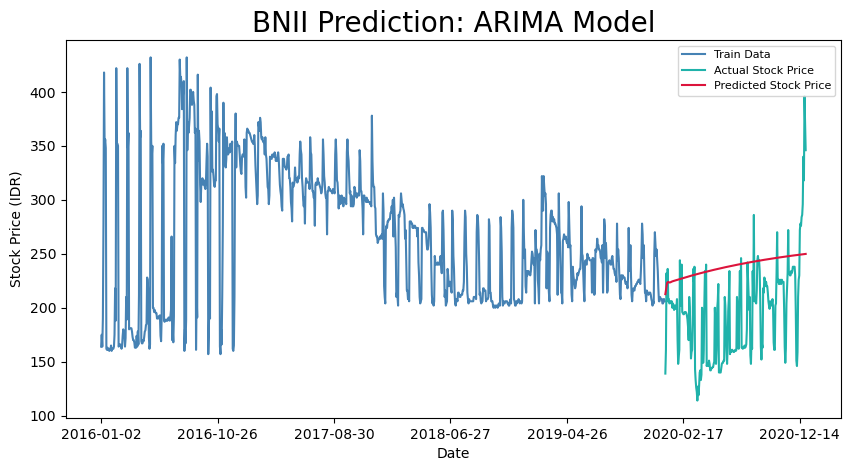

In [16]:
plt.figure(figsize = (10,5), dpi = 100)
plt.plot(bnii_arima_train, label = 'Train Data', color = 'steelblue')
plt.plot(bnii_arima_valid, label = 'Actual Stock Price', color = 'lightseagreen')
plt.plot(fc_series_tuned, label = 'Predicted Stock Price', color = 'crimson')
plt.title('BNII Prediction: ARIMA Model', size = 20)
plt.xticks(ticks = [0, 200, 400, 600, 800, 1000, 1200])
plt.xlabel('Date')
plt.ylabel('Stock Price (IDR)')
plt.legend(loc = 'upper right', fontsize = 8)

plt.savefig('BNII ARIMA.png')
plt.show()

In [17]:
mse_tuned = mean_squared_error(bnii_arima_valid, fc_tuned)
print(f'MSE: {mse_tuned}')
rmse_tuned = math.sqrt(mean_squared_error(bnii_arima_valid, fc_tuned))
print(f'RMSE: {rmse_tuned}')

MSE: 3545.7546392432405
RMSE: 59.54623950547373


**Result Comparison**

In [18]:
pd.set_option('display.float_format', '{:.2f}'.format)
arima_compare = {'Evaluation Method': ['MSE', 'RMSE'], 'Manual Tuning' : [mse, rmse], 'Auto ARIMA Tuning' : [mse_tuned, rmse_tuned]}
pd.DataFrame(arima_compare)

,Evaluation Method,Manual Tuning,Auto ARIMA Tuning
0,MSE,3594.81,3545.75
1,RMSE,59.96,59.55


In [19]:
print(f'Rasio RMSE (Manual Tuning) dengan rata-rata harga saham BNII (validation price mean) adalah {round(rmse/ bnii_arima_valid.mean(), 5)}.')
print(f'Rasio RMSE (Auto ARIMA Tuning) dengan rata-rata harga saham BNII (validation price mean) adalah {round(rmse_tuned/ bnii_arima_valid.mean(), 5)}.')

Rasio RMSE (Manual Tuning) dengan rata-rata harga saham BNII (validation price mean) adalah 0.3067.
Rasio RMSE (Auto ARIMA Tuning) dengan rata-rata harga saham BNII (validation price mean) adalah 0.3046.


Prediksi harga saham BNII menggunakan model ARIMA dengan Auto ARIMA Tuning memberikan hasil prediksi yang paling baik.

#### C.2. LSTM Model

In [20]:
bnii_array = bnii.filter(['Close']).values
bnii_array.shape

(1211, 1)

**Feature Engineering**

In [21]:
scaler = MinMaxScaler()
bnii_scaled = scaler.fit_transform(bnii_array)

**Data Splitting**

In [22]:
bnii_lstm_train = bnii_scaled[0:bnii_train_len, :]

bnii_lstm_x_train, bnii_lstm_y_train = [], []

for i in range(51, bnii_train_len):
    bnii_lstm_x_train.append(bnii_lstm_train[i-51:i, :])
    bnii_lstm_y_train.append(bnii_lstm_train[i, :])

LSTM menerima input data dalam bentuk 3D array, sehingga training data yang akan kita fit ke dalam model harus berbentuk array.

In [23]:
bnii_lstm_x_train, bnii_lstm_y_train = np.array(bnii_lstm_x_train), np.array(bnii_lstm_y_train)

In [24]:
print(f'Shape of x train: {bnii_lstm_x_train.shape}')
print(f'Shape of y train: {bnii_lstm_y_train.shape}')

Shape of x train: (918, 51, 1)
Shape of y train: (918, 1)


**Model Fitting**

Dalam LSTM, terdapat beberapa parameter yang perlu ditentukan terlebih dahulu, yaitu:
- **Hidden Layer** : banyaknya jumlah neuron yang akan digunakan dalam model
- **Dropout** : besarnya peluang model 'melupakan' informasi yang kurang penting dari neuron sebelumnya (saya menggunakan 0.2)
- **History Points** : banyaknya data yang digunakan dalam training untuk satu kali iterasi (saya membagi data training yang totalnya berjumlah 969 data ke dalam 17 iterasi, dengan masing-masing 51 history points per iterasi)
- **Feature Number** : banyaknya feature yang digunakan (dalam hal ini hanya ada 1 feature)
- **Optimizer** (biasanya digunakan optimizer _Adam_)

In [25]:
bnii_lstm = Sequential()
bnii_lstm.add(LSTM(50, return_sequences = False, input_shape = (bnii_lstm_x_train.shape[1], 1)))
bnii_lstm.add(Dropout(0.2))
bnii_lstm.add(Dense(bnii_lstm_y_train.shape[1]))

bnii_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

Jumlah batch size dan epoch yang umumnya digunakan untuk data kecil (ukuran data masih berjumlah ribuan) adalah 32 dan 100.

In [26]:
bnii_lstm.fit(bnii_lstm_x_train, bnii_lstm_y_train, batch_size = 32, epochs = 100)

Epoch 1/100
29/29 [==============================] - 5s 27ms/step - loss: 0.0546
Epoch 2/100
29/29 [==============================] - 1s 22ms/step - loss: 0.0188
Epoch 3/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0177
Epoch 4/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0227
Epoch 5/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0162
Epoch 6/100
29/29 [==============================] - 1s 22ms/step - loss: 0.0171
Epoch 7/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0175
Epoch 8/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0207
Epoch 9/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0159
Epoch 10/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0131
Epoch 11/100
29/29 [==============================] - 1s 31ms/step - loss: 0.0178: 0s - loss: 0.0
Epoch 12/100
29/29 [==============================] - 1s 39ms/step - loss: 0.0154
Epoch 13/

**Predictions**

In [27]:
bnii_lstm_test = bnii_scaled[bnii_train_len - 51:, :]
bnii_lstm_x_test = []
bnii_lstm_y_test = bnii_array[bnii_train_len:, :]

for i in range(51, len(bnii_lstm_test)):
    bnii_lstm_x_test.append(bnii_lstm_test[i-51:i, :])

In [28]:
bnii_lstm_x_test = np.array(bnii_lstm_x_test)

In [29]:
bnii_pred = bnii_lstm.predict(bnii_lstm_x_test)
bnii_pred = scaler.inverse_transform(bnii_pred)

**Model Evaluation**

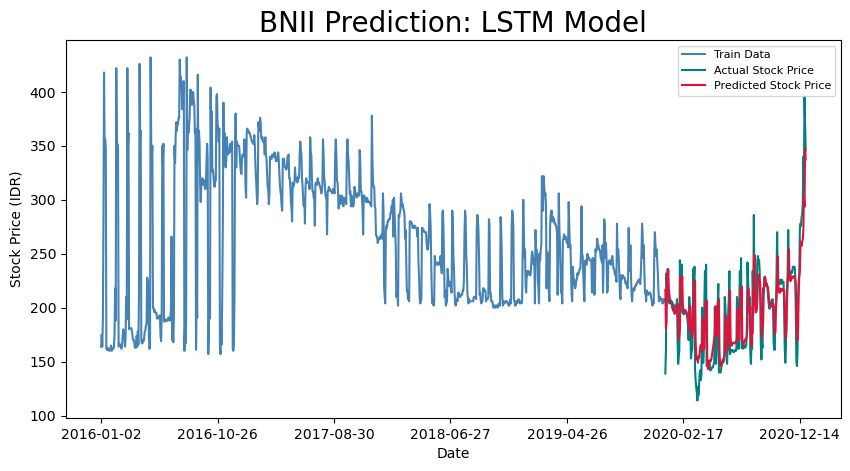

In [30]:
bnii_lstm_train = bnii[:bnii_train_len]
bnii_lstm_valid = bnii[bnii_train_len:]
bnii_lstm_valid['Predictions'] = bnii_pred

plt.figure(figsize = (10,5), dpi = 100)

plt.plot(bnii_lstm_train['Close'], label = 'Train Data', color = 'steelblue')
plt.plot(bnii_lstm_valid['Close'], label = 'Actual Stock Price', color = 'teal')
plt.plot(bnii_lstm_valid['Predictions'], label = 'Predicted Stock Price', color = 'crimson')

plt.title('BNII Prediction: LSTM Model', size = 20)
plt.xticks(ticks = [0, 200, 400, 600, 800, 1000, 1200])
plt.xlabel('Date')
plt.ylabel('Stock Price (IDR)')
plt.legend(loc = 'upper right', fontsize = 8)

plt.savefig('BNII LSTM.png')
plt.show()

In [31]:
mse = mean_squared_error(bnii_pred, bnii_lstm_y_test)
print(f'MSE: {mse}')
rmse = math.sqrt(mean_squared_error(bnii_pred, bnii_lstm_y_test))
print(f'RMSE: {rmse}')

MSE: 626.9766928973523
RMSE: 25.039502648761864


**Manual Tuning**

Saya akan menentukan banyaknya jumlah neuron yang akan digunakan pada LSTM berdasarkan rumus berikut.

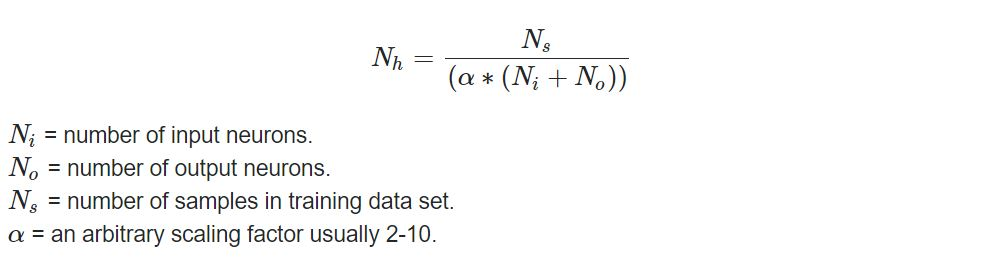

In [32]:
display.Image('./layer_formula.png', width = 600)

Referensi: https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

Dengan parameter:
- Jumlah input adalah 51.
- Jumlah output adalah 1
- Jumlah sampel adalah 969 (sebanyak training data)
- Nilai alpha yang saya gunakan adalah 10

Sehingga diperoleh jumlah layer sebanyak 2 layer.

In [33]:
bnii_lstm_tuned = Sequential()
bnii_lstm_tuned.add(LSTM(2, return_sequences = False, input_shape = (bnii_lstm_x_train.shape[1], 1)))
bnii_lstm_tuned.add(Dropout(0.2))
bnii_lstm_tuned.add(Dense(bnii_lstm_y_train.shape[1]))

bnii_lstm_tuned.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [34]:
bnii_lstm_tuned.fit(bnii_lstm_x_train, bnii_lstm_y_train, batch_size = 32, epochs = 100)

Epoch 1/100
29/29 [==============================] - 4s 18ms/step - loss: 0.1764
Epoch 2/100
29/29 [==============================] - 0s 17ms/step - loss: 0.1190
Epoch 3/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0746
Epoch 4/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0569
Epoch 5/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0444
Epoch 6/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0392
Epoch 7/100
29/29 [==============================] - 0s 17ms/step - loss: 0.0552
Epoch 8/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0340
Epoch 9/100
29/29 [==============================] - 1s 17ms/step - loss: 0.0417
Epoch 10/100
29/29 [==============================] - 0s 16ms/step - loss: 0.0378
Epoch 11/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0378
Epoch 12/100
29/29 [==============================] - 0s 17ms/step - loss: 0.0347
Epoch 13/100
29/29 [=====

In [35]:
bnii_pred_tuned = bnii_lstm_tuned.predict(bnii_lstm_x_test)
bnii_pred_tuned = scaler.inverse_transform(bnii_pred_tuned)

**Model Evaluation**

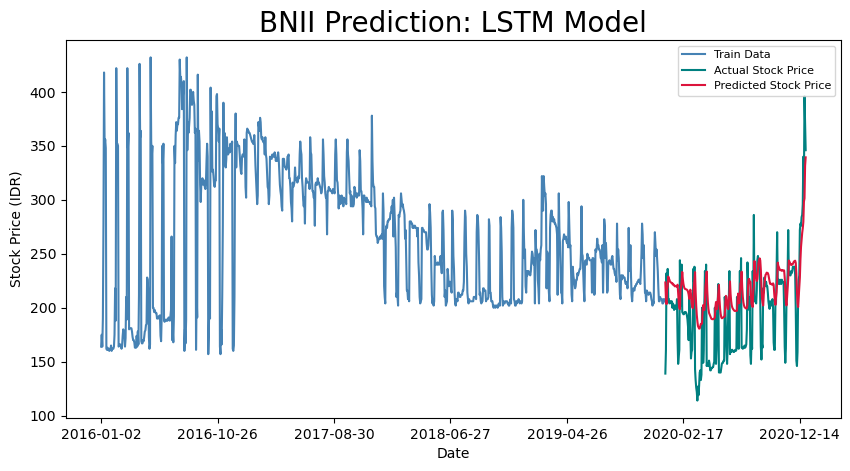

In [36]:
bnii_lstm_train = bnii[:bnii_train_len]
bnii_lstm_valid = bnii[bnii_train_len:]
bnii_lstm_valid['Predictions'] = bnii_pred_tuned

plt.figure(figsize = (10,5), dpi = 100)

plt.plot(bnii_lstm_train['Close'], label = 'Train Data', color = 'steelblue')
plt.plot(bnii_lstm_valid['Close'], label = 'Actual Stock Price', color = 'teal')
plt.plot(bnii_lstm_valid['Predictions'], label = 'Predicted Stock Price', color = 'crimson')

plt.title('BNII Prediction: LSTM Model', size = 20)
plt.xticks(ticks = [0, 200, 400, 600, 800, 1000, 1200])
plt.xlabel('Date')
plt.ylabel('Stock Price (IDR)')
plt.legend(loc = 'upper right', fontsize = 8)

plt.show()

In [37]:
mse_tuned = mean_squared_error(bnii_pred_tuned, bnii_lstm_y_test)
print(f'MSE: {mse_tuned}')
rmse_tuned = math.sqrt(mean_squared_error(bnii_pred_tuned, bnii_lstm_y_test))
print(f'RMSE: {rmse_tuned}')

MSE: 1401.5830604483072
RMSE: 37.43772242602783


**Result Comparison**

In [38]:
pd.set_option('display.float_format', '{:.2f}'.format)
lstm_compare = {'Evaluation Method': ['MSE', 'RMSE'], 'Random Parameter' : [mse, rmse], 'Manual Tuning' : [mse_tuned, rmse_tuned]}
pd.DataFrame(lstm_compare)

,Evaluation Method,Random Parameter,Manual Tuning
0,MSE,626.98,1401.58
1,RMSE,25.04,37.44


In [39]:
rmse_ratio = rmse/ bnii_lstm_valid['Close'].mean()
rmse_tuned_ratio = rmse_tuned/ bnii_lstm_valid['Close'].mean()

In [40]:
print(f'Rasio RMSE (Random Parameter) dengan rata-rata harga saham BNII (validation price mean) adalah {round(rmse_ratio, 5)}.')
print(f'Rasio RMSE (Manual Tuning) dengan rata-rata harga saham BNII (validation price mean) adalah {round(rmse_tuned_ratio, 5)}.')

Rasio RMSE (Random Parameter) dengan rata-rata harga saham BNII (validation price mean) adalah 0.12808.
Rasio RMSE (Manual Tuning) dengan rata-rata harga saham BNII (validation price mean) adalah 0.19151.


Prediksi harga saham BNII menggunakan model LSTM dengan random parameter memberikan hasil prediksi yang paling baik.

</br>

### 5. Deployment

Model LSTM dengan random parameter memberikan nilai RMSE yang paling kecil (nilai prediksinya baik dan mendekati harga saham sesungguhnya). Oleh karena itu, saya akan menyimpan model tersebut untuk digunakan dalam deployment selanjutnya.

In [41]:
bnii_lstm.save('bnii_lstm_model.h5')